In [1]:
from preprocessing import DicomMontageDataset, create_train_test_val

In [2]:
dataset_dataloader_dict = create_train_test_val("dataset", "dataset/labels_binary.csv", batch_size=8, num_workers=4, test_size=0.25, val_size=0.5, random_state=42)

train_dataset = dataset_dataloader_dict["train_dataset"]
val_dataset = dataset_dataloader_dict["val_dataset"]
test_dataset = dataset_dataloader_dict["test_dataset"]
train_loader = dataset_dataloader_dict["train_loader"]
val_loader = dataset_dataloader_dict["val_loader"]
test_loader = dataset_dataloader_dict["test_loader"]

Extracting labels and filtering corrupted samples...


100%|████████████████████████████████████████████████████████████████████████████████████████| 104/104 [07:52<00:00,  4.55s/it]


In [3]:
from monai.networks.nets import SEResNet50
import torch.nn as nn
import torch

# Load pretrained SE-ResNet50 3D
# Create SE-ResNet50 3D model for binary classification
model = SEResNet50(
    spatial_dims=3,
    in_channels=1,      # Use this instead of n_input_channels
    num_classes=2       # For binary classification
)

# Optional: move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## Optionally freeze early layers to prevent fine tuning the whole network
# for param in model.layer1.parameters():
#     param.requires_grad = False

num_epochs = 10

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # (B, 1, 10, 224, 224)=
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            _, val_predicted = val_outputs.max(1)
            val_correct += val_predicted.eq(val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")

Epoch 1/10, Train Loss: 6.8653, Train Accuracy: 50.00%
Validation Loss: 1.3763, Validation Accuracy: 53.85%

Epoch 2/10, Train Loss: 7.0963, Train Accuracy: 58.97%
Validation Loss: 1.3972, Validation Accuracy: 53.85%

Epoch 3/10, Train Loss: 6.8697, Train Accuracy: 58.97%
Validation Loss: 1.3924, Validation Accuracy: 53.85%

Epoch 4/10, Train Loss: 6.6395, Train Accuracy: 53.85%
Validation Loss: 1.3827, Validation Accuracy: 53.85%

Epoch 5/10, Train Loss: 7.3488, Train Accuracy: 48.72%
Validation Loss: 1.4838, Validation Accuracy: 46.15%

Epoch 6/10, Train Loss: 7.0665, Train Accuracy: 51.28%
Validation Loss: 1.4212, Validation Accuracy: 46.15%

Epoch 7/10, Train Loss: 6.9738, Train Accuracy: 57.69%
Validation Loss: 1.5404, Validation Accuracy: 46.15%

Epoch 8/10, Train Loss: 7.2112, Train Accuracy: 48.72%
Validation Loss: 1.4170, Validation Accuracy: 46.15%

Epoch 9/10, Train Loss: 7.2363, Train Accuracy: 55.13%
Validation Loss: 1.3772, Validation Accuracy: 53.85%

Epoch 10/10, Train 

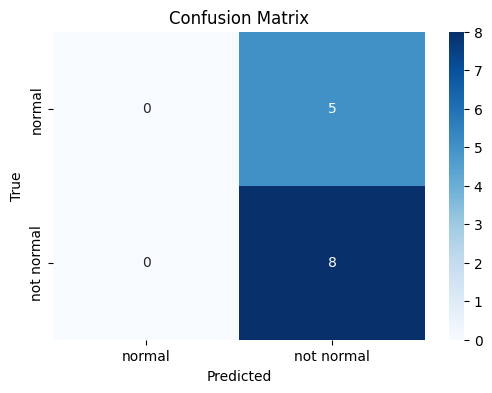

Test Loss: 0.6682
Test Accuracy: 61.54%
Precision: 0.3787
Recall: 0.6154


(0.6681779623031616,
 61.53846153846154,
 0.37869822485207105,
 0.6153846153846154)

In [4]:
#Test the model 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def test_model(model, test_loader, criterion, device, class_names):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation for speed
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total

     # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(cm.shape[0]),
                yticklabels=class_names if class_names else range(cm.shape[0]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision and Recall
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return avg_loss, accuracy, precision, recall

class_names = ["normal", "not normal"] 
test_model(model, test_loader, criterion, device, class_names)